In [ ]:
from matplotlib import pyplot as plt
from typing import Tuple, Any
import cv2
import random
import numpy as np
import pandas as pd
import os
import torch.nn as nn
from PIL import Image
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

In [13]:
csv = "D:/python/annotation_dataset.csv"
data = pd.read_csv(csv,  usecols=[0, 2])
(data)

,absolute_path,class
0,D:\python\dataset\leopard\0000.jpg,leopard
1,D:\python\dataset\leopard\0001.jpg,leopard
2,D:\python\dataset\leopard\0002.jpg,leopard
3,D:\python\dataset\leopard\0003.jpg,leopard
4,D:\python\dataset\leopard\0004.jpg,leopard
...,...,...
2035,D:\python\dataset\tiger\1015.jpg,tiger
2036,D:\python\dataset\tiger\1016.jpg,tiger
2037,D:\python\dataset\tiger\1017.jpg,tiger
2038,D:\python\dataset\tiger\1018.jpg,tiger


In [14]:
names = set(data["class"].to_list())

In [15]:
splited_by_class, train_list, test_list, val_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
i = 0
for name in names:
    splited_by_class = data.loc[data['class'] == name]
    train_list = pd.concat([train_list, splited_by_class[0 : int(len(splited_by_class) * 0.8)]], )
    test_list = pd.concat([test_list, splited_by_class[int(len(splited_by_class) * 0.8) : int(len(splited_by_class) * 0.9)]], ignore_index = True)
    val_list = pd.concat([val_list, splited_by_class[int(len(splited_by_class) * 0.9) : int(len(splited_by_class))]], ignore_index = True)
    i+=1
print(len(train_list), len(test_list), len(val_list))

1632 204 204


Проверка на сбалансированность

In [16]:
train_stats = train_list['class'].value_counts()
test_stats = train_list['class'].value_counts()
val_stats = train_list['class'].value_counts()
if not train_stats.min() / train_stats.max() >= 0.98:
    print("not ok")
elif not test_stats.min() / test_stats.max() >= 0.98:
    print("not ok")
elif not val_stats.min() / val_stats.max() >= 0.98:
    print("not ok")
else:
    print("ok")

ok


Класс для хранения картинок

In [17]:
class CustomDataset(torch.utils.data.Dataset):
  """Class to store images"""
  def __init__(self, images, transform:Any=None) -> None:
        self.dataset = images
        self.transform = transform

  def __len__(self) -> int:
    return len(self.dataset)

  def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
    path_to_image = self.dataset.iloc[index, 0]
    image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
    image = self.transform(image)
    label = self.dataset.iloc[index, 1]

    if label == "tiger":
       label = 0
    elif label == "leopard":
       label = 1

    return image, label

Предобработка

In [7]:
train_list.iloc[0]

absolute_path    D:\python\dataset\leopard\0000.jpg
class                                       leopard
Name: 0, dtype: object

In [21]:
custom_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        ]
)
train_data = CustomDataset(train_list, transform=custom_transforms)
test_data = CustomDataset(test_list, transform=custom_transforms)
val_data = CustomDataset(val_list, transform=custom_transforms)
test_data[100]

(tensor([[[0.2353, 0.2430, 0.2440,  ..., 0.1217, 0.1296, 0.1373],
          [0.2353, 0.2430, 0.2440,  ..., 0.1217, 0.1296, 0.1373],
          [0.2353, 0.2430, 0.2440,  ..., 0.1217, 0.1296, 0.1373],
          ...,
          [0.6995, 0.6972, 0.6763,  ..., 0.3081, 0.3095, 0.3098],
          [0.6745, 0.7058, 0.6877,  ..., 0.3020, 0.3047, 0.3098],
          [0.6927, 0.7228, 0.7012,  ..., 0.3020, 0.3047, 0.3098]],
 
         [[0.1961, 0.1986, 0.1969,  ..., 0.1211, 0.1270, 0.1373],
          [0.1961, 0.1986, 0.1969,  ..., 0.1211, 0.1270, 0.1373],
          [0.1961, 0.1986, 0.1969,  ..., 0.1211, 0.1270, 0.1373],
          ...,
          [0.4442, 0.4446, 0.4386,  ..., 0.2532, 0.2546, 0.2549],
          [0.4164, 0.4519, 0.4502,  ..., 0.2471, 0.2498, 0.2549],
          [0.4327, 0.4679, 0.4636,  ..., 0.2471, 0.2498, 0.2549]],
 
         [[0.1490, 0.1465, 0.1410,  ..., 0.1015, 0.1033, 0.1059],
          [0.1490, 0.1465, 0.1393,  ..., 0.1015, 0.1033, 0.1059],
          [0.1490, 0.1465, 0.1392,  ...,

In [9]:
train_data[0][0].shape

torch.Size([3, 224, 224])

Модель свёрточной нейросети

In [8]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(576,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = output.view(output.size(0),-1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        return output

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = CNN()
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Графики

In [10]:
def chart(epochs, train_acc, train_loss, valid_acc, valid_loss) -> None:
    """Creates graphs based on the learning results"""
    fig=plt.figure(figsize=(20, 5))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Neural network training results')
    print(train_loss)
    plt.plot(range(epochs), train_acc, color='green', linestyle='-', linewidth=1, label='Train accuracy') 
    plt.plot(range(epochs) ,train_loss , color='red', linestyle='--', linewidth=1, label='Train loss')
    plt.legend() 
    plt.show()

    fig=plt.figure(figsize=(20, 10))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Neural network training results')
    plt.plot(range(epochs), valid_acc, color='green', linestyle='-', linewidth=1, label='Validation accuracy') 
    plt.plot(range(epochs) ,valid_loss , color='red', linestyle='--', linewidth=1, label='Validation loss')
    plt.legend() 
    plt.show()

In [57]:
def train_loop(epochs, batch_size, lear) -> Tuple[list, CNN]:
    optimizer = optim.Adam(params=model.parameters(), lr=lear)
    criterion = nn.CrossEntropyLoss()
    train_accuracy_values = []
    train_loss_values = []

    val_accuracy_values = []
    val_loss_values = []
    valid_loader = torch.utils.data.DataLoader(
        dataset=val_data, batch_size=batch_size, shuffle=False
    )
    train_loader = torch.utils.data.DataLoader(
        dataset=train_data, batch_size=batch_size, shuffle=True
    )
    

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0


        model.train()
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()

            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)
        print(
           f"Epoch : {epoch + 1}, train accuracy : {epoch_accuracy}, train loss : {epoch_loss}"
        )
        train_accuracy_values.append(epoch_accuracy)
        train_loss_values.append(epoch_loss.detach().numpy())
        model.eval()
        epoch_val_loss = 0
        epoch_val_accuracy = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()

            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += loss / len(valid_loader)

        val_accuracy_values.append(epoch_val_accuracy)
        val_loss_values.append(epoch_val_loss.detach().numpy())

        print(
                f"Epoch : {epoch + 1}, val_accuracy : {epoch_val_accuracy}, val_loss : {epoch_val_loss}"
            )
    chart(epochs, train_accuracy_values, train_loss_values, val_accuracy_values, val_loss_values)

Обучение.

Epoch : 1, train accuracy : 0.8224265575408936, train loss : 0.3871157765388489
Epoch : 1, val_accuracy : 0.8799999952316284, val_loss : 0.3404253125190735
Epoch : 2, train accuracy : 0.8525000810623169, train loss : 0.350637823343277
Epoch : 2, val_accuracy : 0.84333336353302, val_loss : 0.35965049266815186
Epoch : 3, train accuracy : 0.860514760017395, train loss : 0.3177954852581024
Epoch : 3, val_accuracy : 0.7333333492279053, val_loss : 0.5887688398361206
Epoch : 4, train accuracy : 0.8746323585510254, train loss : 0.30147573351860046
Epoch : 4, val_accuracy : 0.8233333230018616, val_loss : 0.45233482122421265
Epoch : 5, train accuracy : 0.8863235116004944, train loss : 0.2598833441734314
Epoch : 5, val_accuracy : 0.903333306312561, val_loss : 0.24886438250541687
Epoch : 6, train accuracy : 0.8566176295280457, train loss : 0.30619627237319946
Epoch : 6, val_accuracy : 0.7633333206176758, val_loss : 0.572659969329834
Epoch : 7, train accuracy : 0.8797059655189514, train loss : 0.26

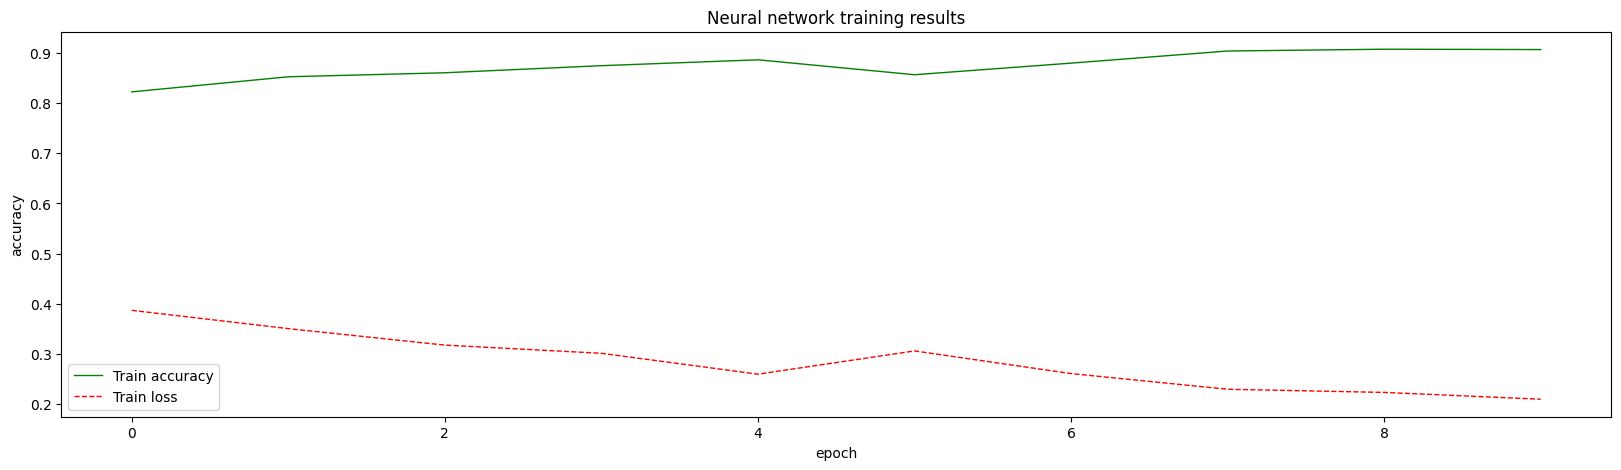

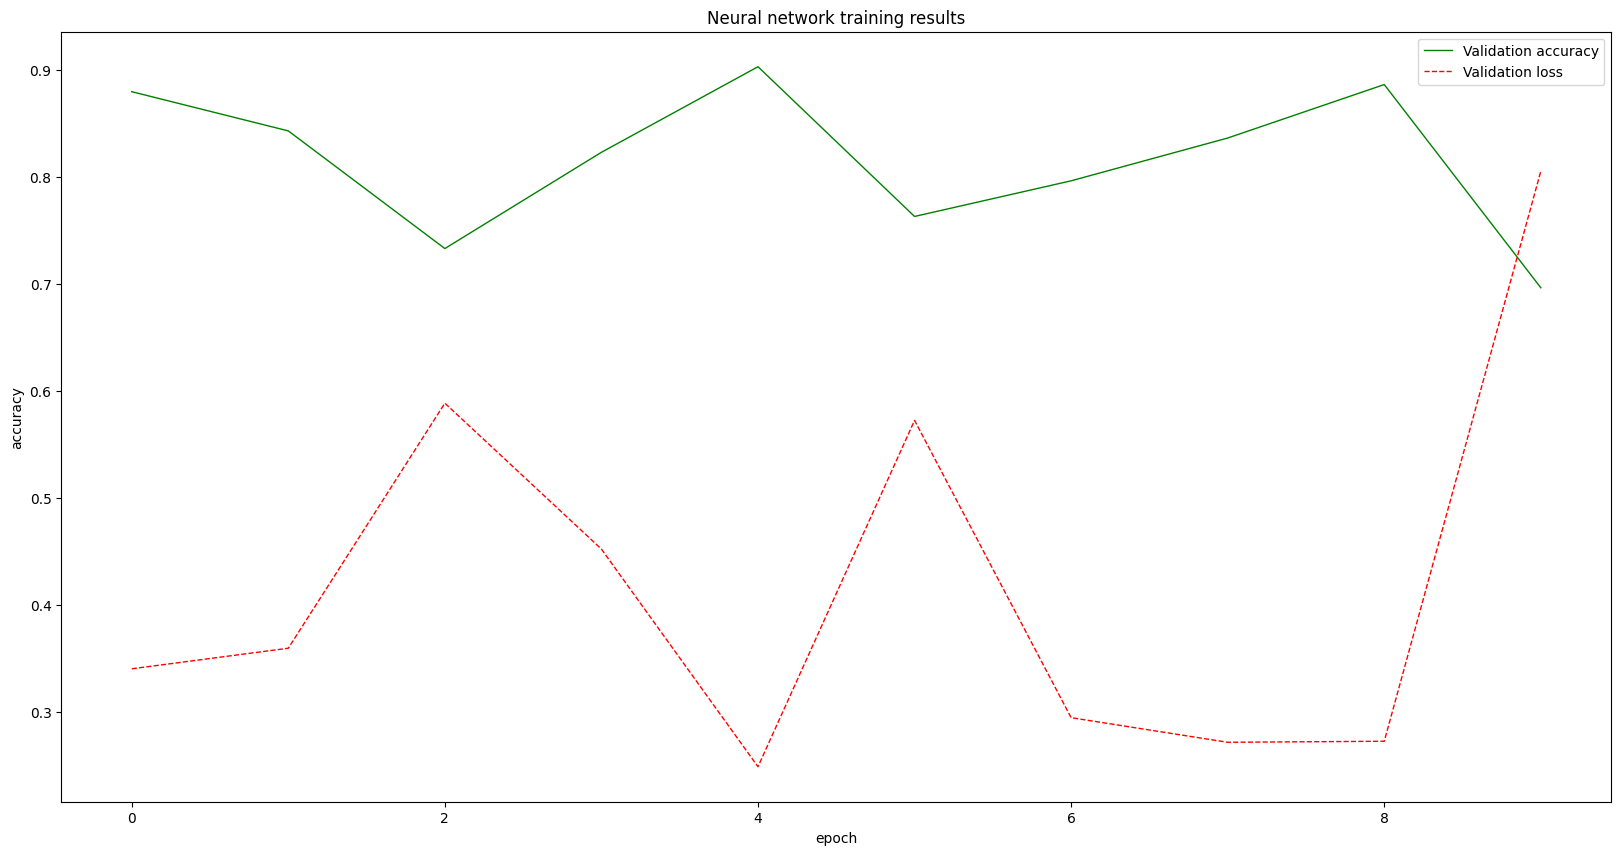

In [19]:
train_loop(10, 100, 0.001)

Epoch : 1, train accuracy : 0.8991667032241821, train loss : 0.2203536331653595
Epoch : 1, val_accuracy : 0.9300000071525574, val_loss : 0.15870507061481476
Epoch : 2, train accuracy : 0.8899999856948853, train loss : 0.24677200615406036
Epoch : 2, val_accuracy : 0.8125, val_loss : 0.3680484890937805
Epoch : 3, train accuracy : 0.9104166626930237, train loss : 0.21683016419410706
Epoch : 3, val_accuracy : 0.6475000381469727, val_loss : 0.9622809886932373
Epoch : 4, train accuracy : 0.9013888835906982, train loss : 0.20077961683273315
Epoch : 4, val_accuracy : 0.8725000023841858, val_loss : 0.30811095237731934
Epoch : 5, train accuracy : 0.9225000143051147, train loss : 0.19782382249832153
Epoch : 5, val_accuracy : 0.7949999570846558, val_loss : 0.7736104726791382
Epoch : 6, train accuracy : 0.9259722232818604, train loss : 0.17961004376411438
Epoch : 6, val_accuracy : 0.9199999570846558, val_loss : 0.18747487664222717
Epoch : 7, train accuracy : 0.927361249923706, train loss : 0.166045

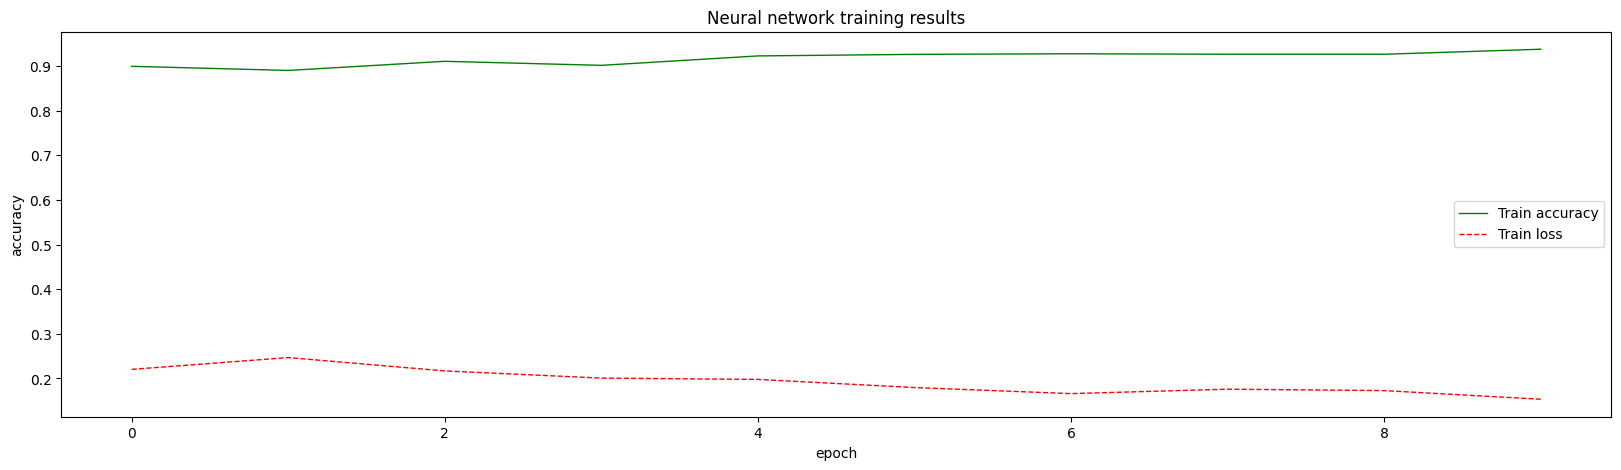

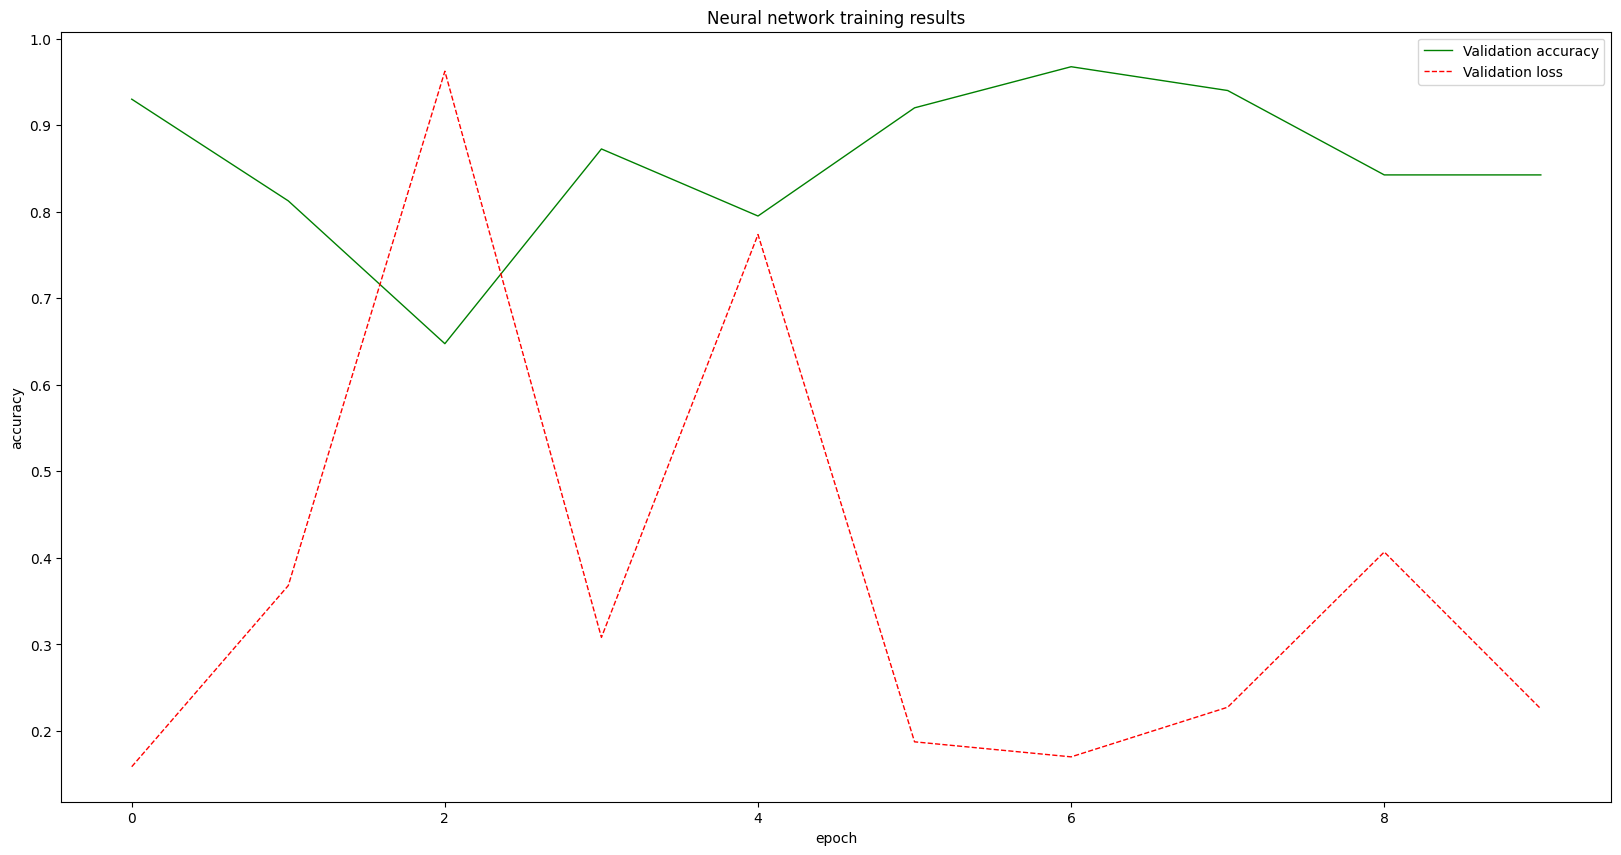

In [20]:
train_loop(10, 200, 0.001)

Epoch : 1, train accuracy : 0.918999969959259, train loss : 0.17749962210655212
Epoch : 1, val_accuracy : 0.656862735748291, val_loss : 1.6763663291931152
Epoch : 2, train accuracy : 0.940500020980835, train loss : 0.1595977246761322
Epoch : 2, val_accuracy : 0.8039215803146362, val_loss : 0.5134238004684448
Epoch : 3, train accuracy : 0.9157500267028809, train loss : 0.17406558990478516
Epoch : 3, val_accuracy : 0.7009803652763367, val_loss : 1.013542890548706
Epoch : 4, train accuracy : 0.9137500524520874, train loss : 0.19256651401519775
Epoch : 4, val_accuracy : 0.8186274766921997, val_loss : 0.4342799484729767
Epoch : 5, train accuracy : 0.9354999661445618, train loss : 0.15720698237419128
Epoch : 5, val_accuracy : 0.7107843160629272, val_loss : 0.8423948884010315
Epoch : 6, train accuracy : 0.9424999952316284, train loss : 0.1387443095445633
Epoch : 6, val_accuracy : 0.6960784196853638, val_loss : 0.7278698682785034
Epoch : 7, train accuracy : 0.934249997138977, train loss : 0.16

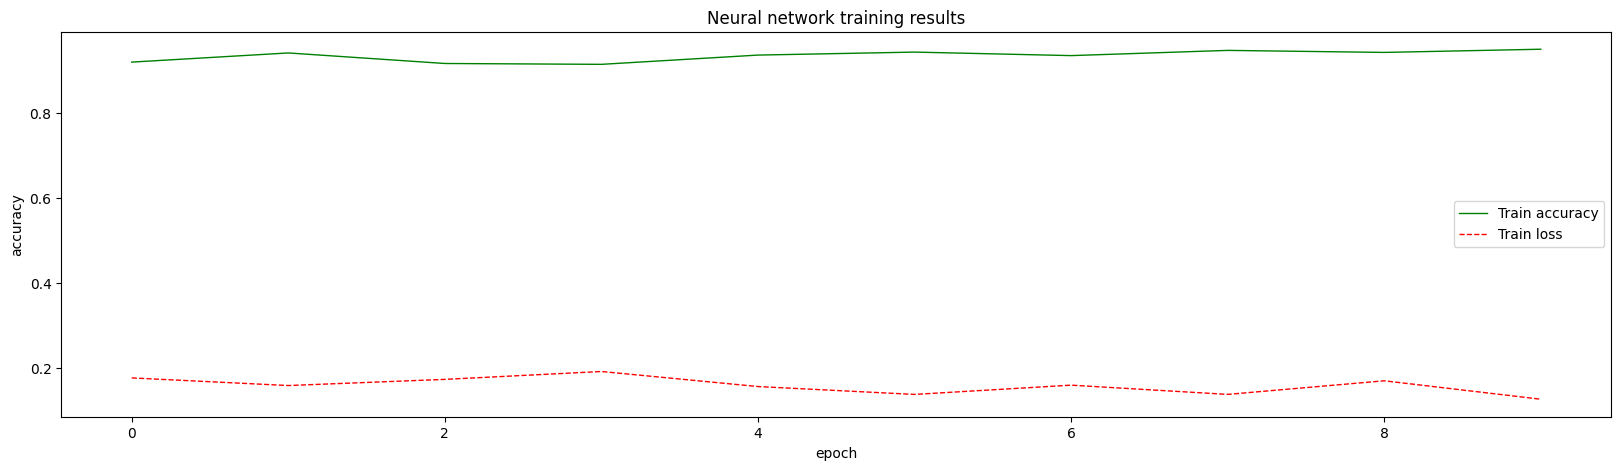

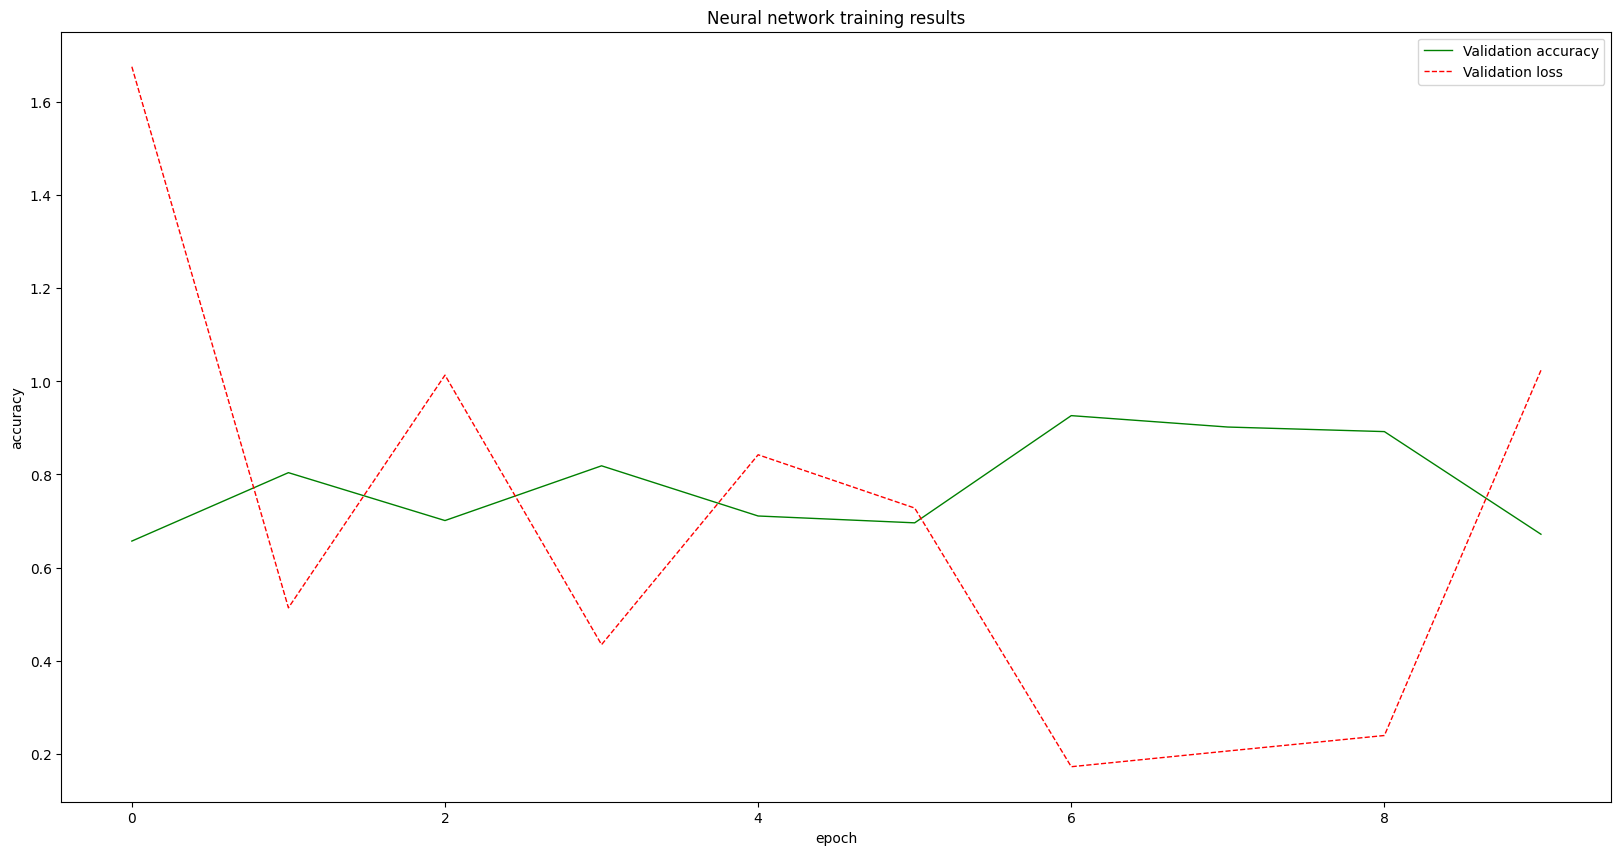

In [21]:
train_loop(10, 400, 0.001)

Epoch : 1, train accuracy : 0.8990440964698792, train loss : 0.23074345290660858
Epoch : 1, val_accuracy : 0.8366667032241821, val_loss : 0.49240678548812866
Epoch : 2, train accuracy : 0.9137500524520874, train loss : 0.21237726509571075
Epoch : 2, val_accuracy : 0.9300000667572021, val_loss : 0.22018921375274658
Epoch : 3, train accuracy : 0.928676426410675, train loss : 0.17371782660484314
Epoch : 3, val_accuracy : 0.7500000596046448, val_loss : 0.37612295150756836
Epoch : 4, train accuracy : 0.9150000214576721, train loss : 0.19135496020317078
Epoch : 4, val_accuracy : 0.9166667461395264, val_loss : 0.23356468975543976
Epoch : 5, train accuracy : 0.9275735020637512, train loss : 0.16941241919994354
Epoch : 5, val_accuracy : 0.8899999856948853, val_loss : 0.19411928951740265
Epoch : 6, train accuracy : 0.9435293078422546, train loss : 0.1312096118927002
Epoch : 6, val_accuracy : 0.9233332872390747, val_loss : 0.16885079443454742
Epoch : 7, train accuracy : 0.9357351660728455, train 

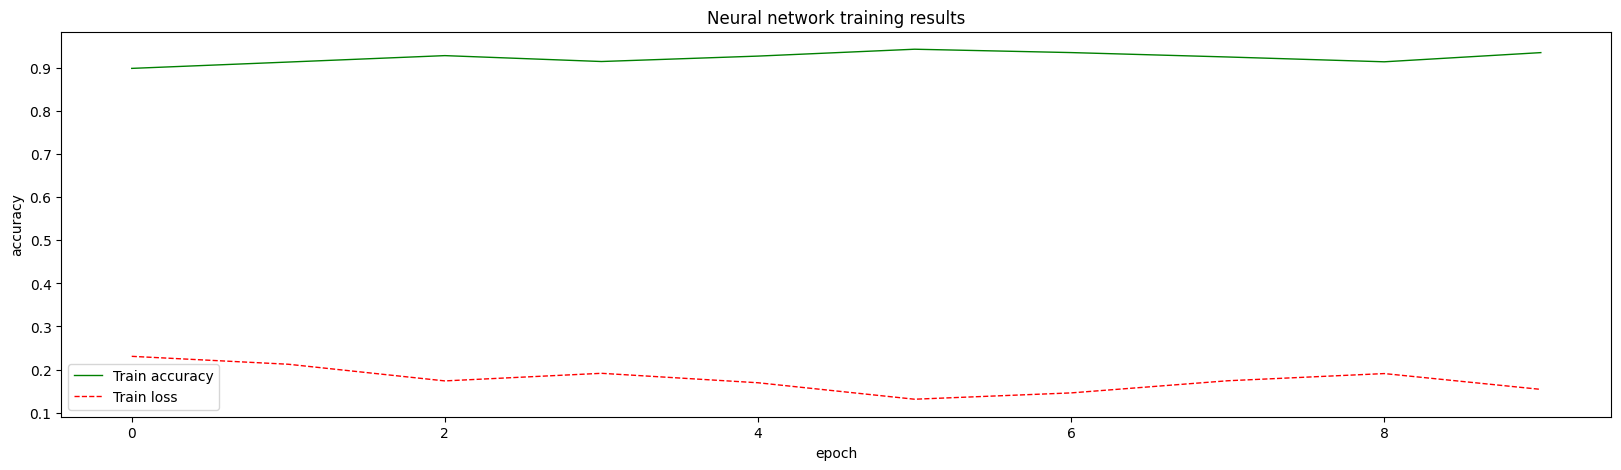

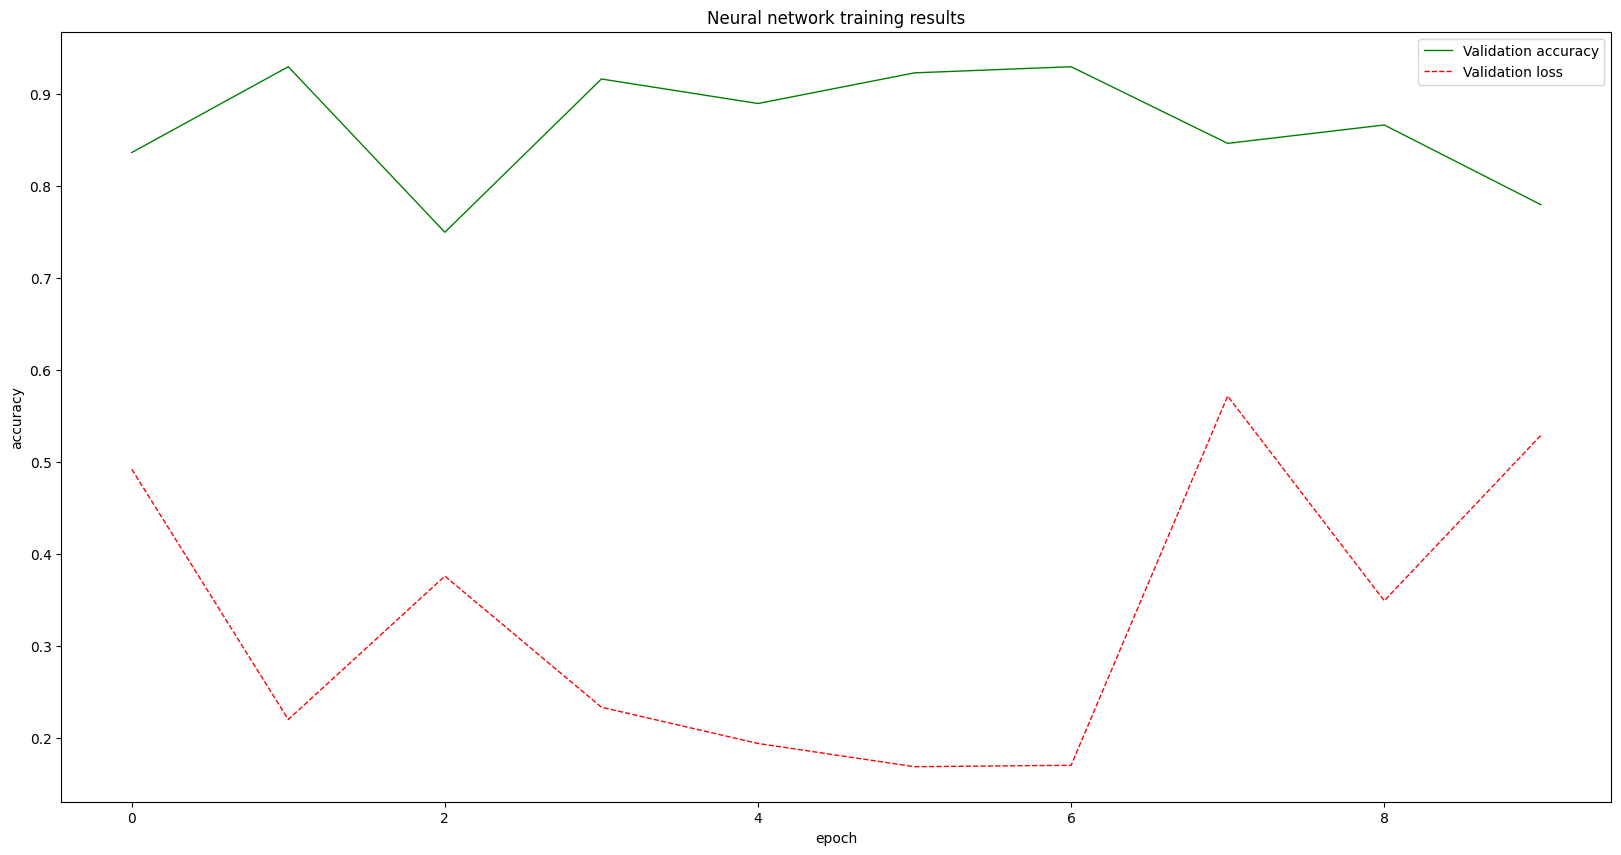

In [22]:
train_loop(10, 100, 0.002)

Epoch : 1, train accuracy : 0.8641912341117859, train loss : 0.33751988410949707
Epoch : 1, val_accuracy : 0.9466667175292969, val_loss : 0.18638022243976593
Epoch : 2, train accuracy : 0.9287499189376831, train loss : 0.17841841280460358
Epoch : 2, val_accuracy : 0.9466667175292969, val_loss : 0.15782974660396576
Epoch : 3, train accuracy : 0.9322057962417603, train loss : 0.1682313233613968
Epoch : 3, val_accuracy : 0.8700000047683716, val_loss : 0.27012985944747925
Epoch : 4, train accuracy : 0.9248528480529785, train loss : 0.16750943660736084
Epoch : 4, val_accuracy : 0.9233332872390747, val_loss : 0.21758854389190674
Epoch : 5, train accuracy : 0.9411764740943909, train loss : 0.15733465552330017
Epoch : 5, val_accuracy : 0.7433333396911621, val_loss : 0.9390230774879456
Epoch : 6, train accuracy : 0.9225736260414124, train loss : 0.180623397231102
Epoch : 6, val_accuracy : 0.9133334159851074, val_loss : 0.2136756032705307
Epoch : 7, train accuracy : 0.938823401927948, train loss

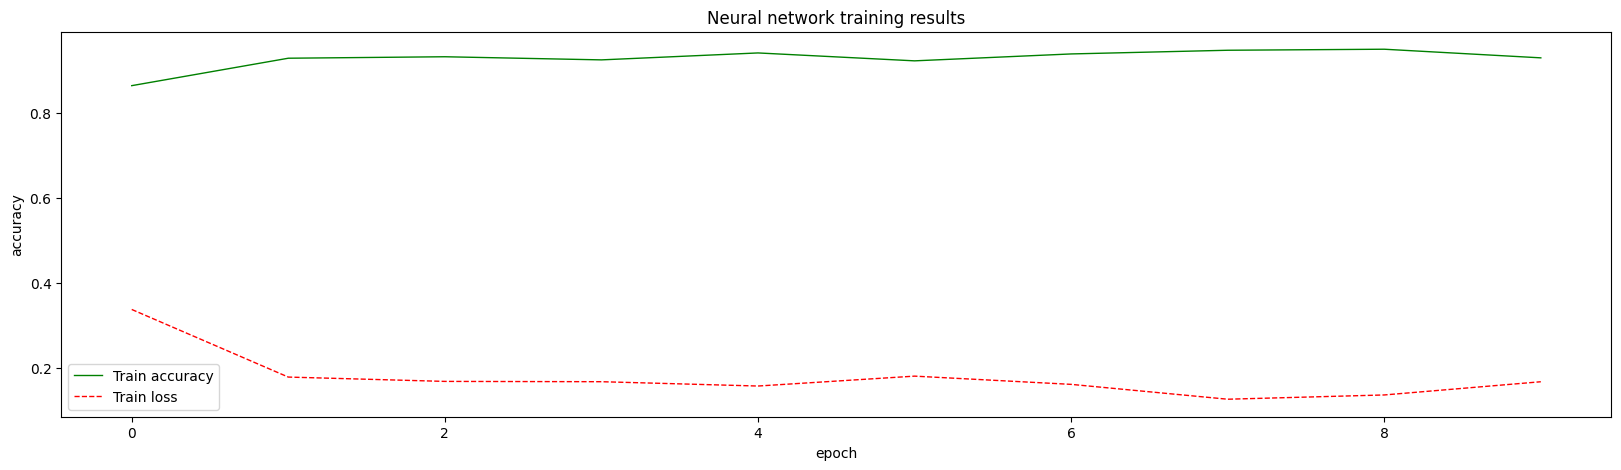

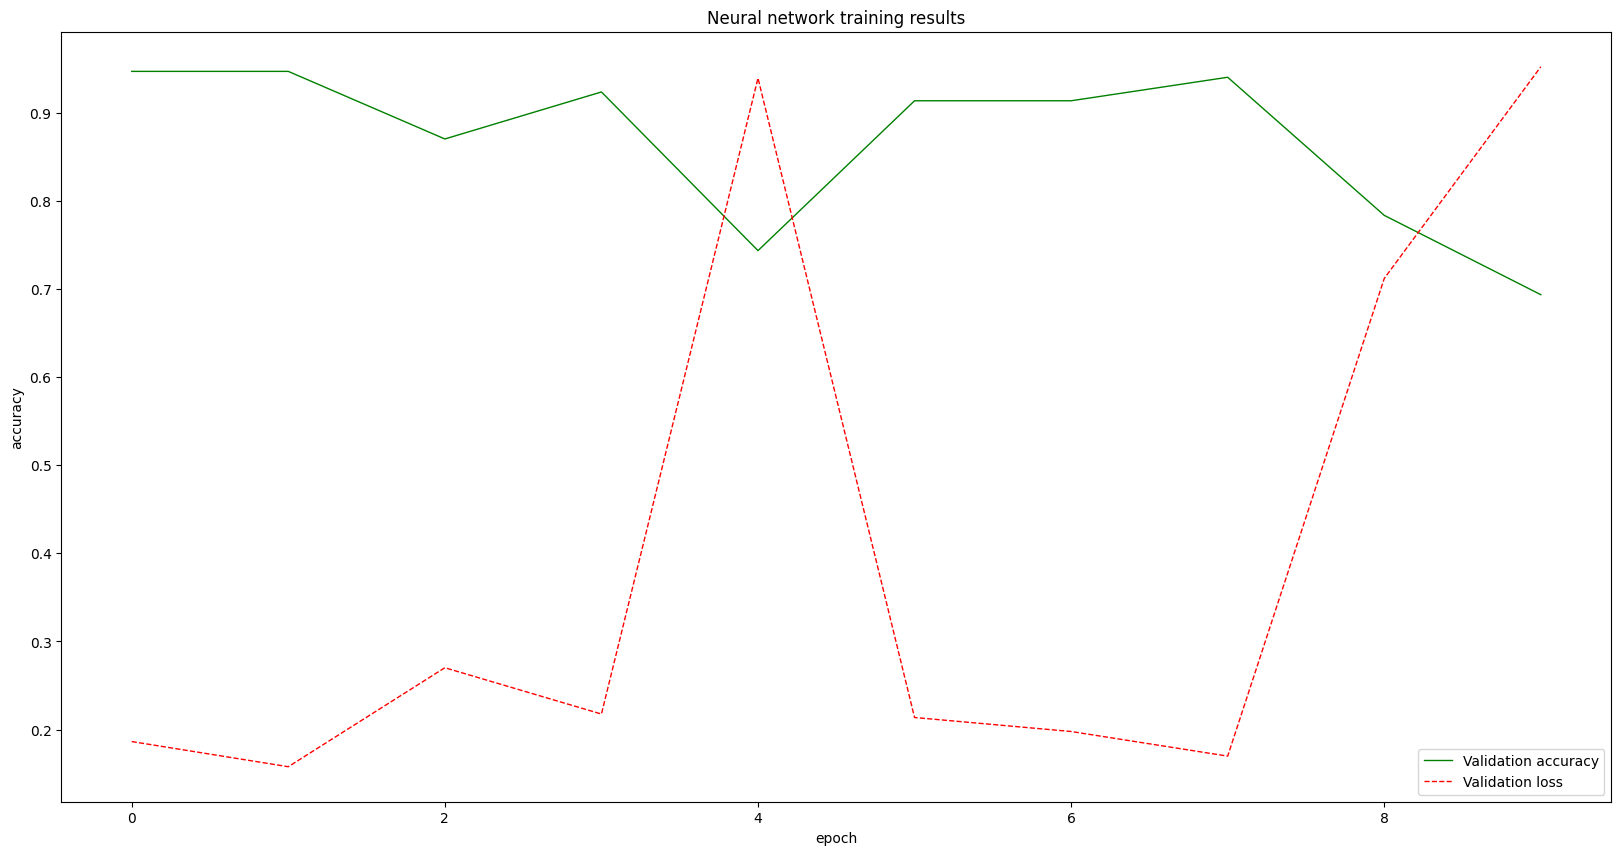

In [23]:
train_loop(10, 100, 0.003)

Epoch : 1, train accuracy : 0.9516666531562805, train loss : 0.13447144627571106
Epoch : 1, val_accuracy : 0.9524999856948853, val_loss : 0.13314637541770935
Epoch : 2, train accuracy : 0.9565277695655823, train loss : 0.1130930706858635
Epoch : 2, val_accuracy : 0.8274999856948853, val_loss : 0.25337377190589905
Epoch : 3, train accuracy : 0.9479166269302368, train loss : 0.11012245714664459
Epoch : 3, val_accuracy : 0.9325000047683716, val_loss : 0.165376216173172
Epoch : 4, train accuracy : 0.9622222185134888, train loss : 0.10137125104665756
Epoch : 4, val_accuracy : 0.9175000190734863, val_loss : 0.24442605674266815
Epoch : 5, train accuracy : 0.95374995470047, train loss : 0.10576885938644409
Epoch : 5, val_accuracy : 0.9399999976158142, val_loss : 0.17592322826385498
Epoch : 6, train accuracy : 0.9683333039283752, train loss : 0.08329720050096512
Epoch : 6, val_accuracy : 0.8075000047683716, val_loss : 0.34979721903800964
Epoch : 7, train accuracy : 0.9383333921432495, train los

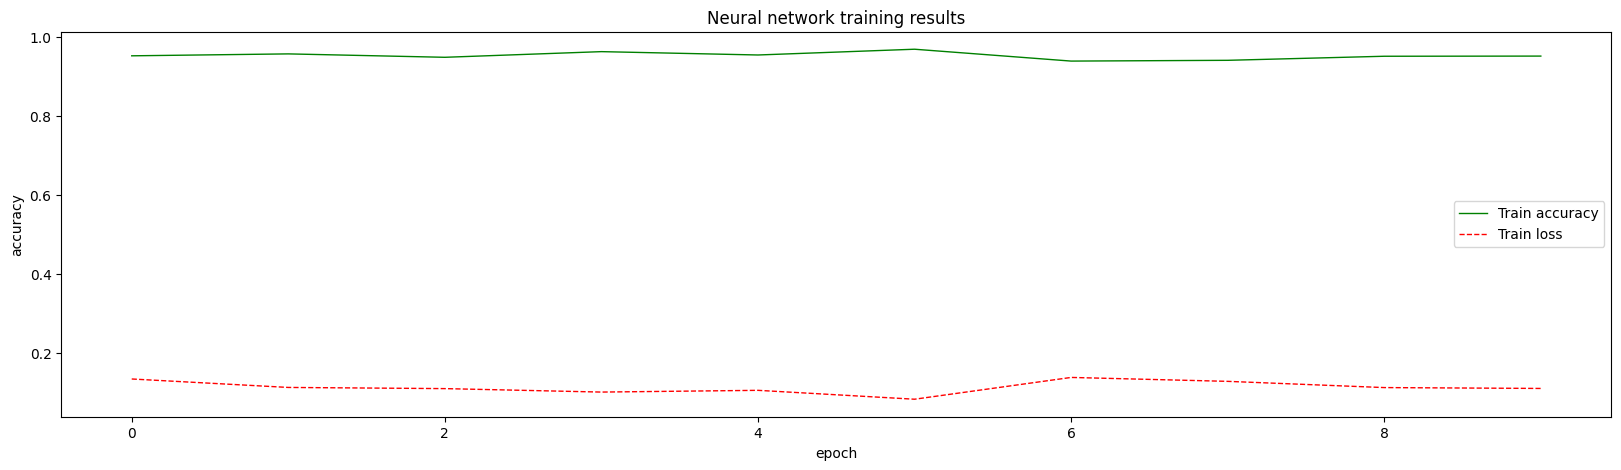

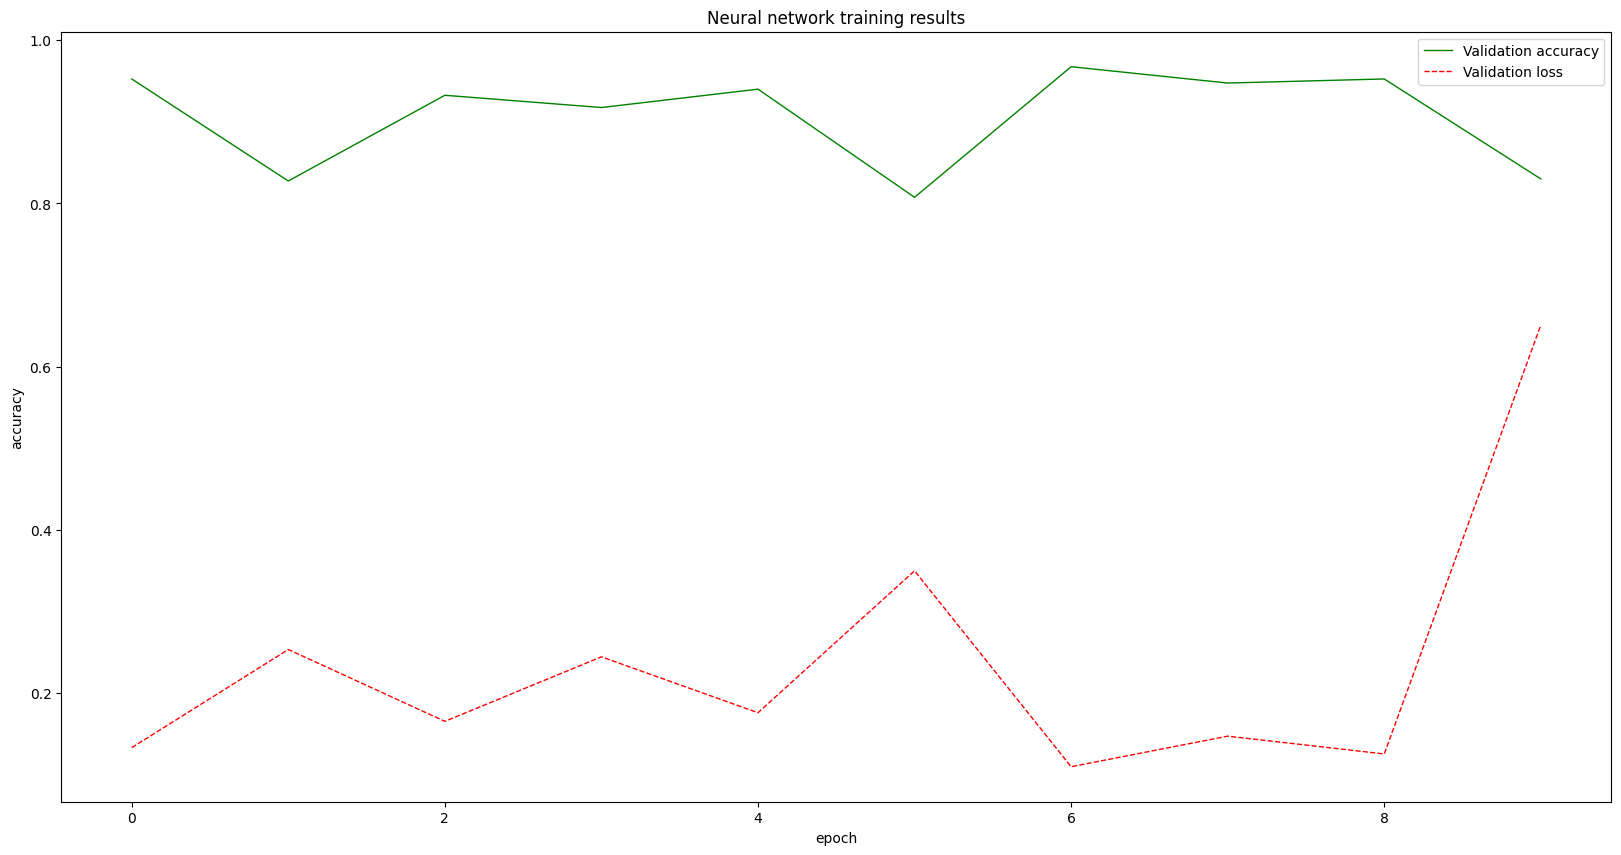

In [24]:
train_loop(10, 200, 0.002)

Epoch : 1, train accuracy : 0.9509999752044678, train loss : 0.15549533069133759
Epoch : 1, val_accuracy : 0.8578431606292725, val_loss : 0.3013913333415985
Epoch : 2, train accuracy : 0.940750002861023, train loss : 0.1319921910762787
Epoch : 2, val_accuracy : 0.7941176295280457, val_loss : 0.5735505819320679
Epoch : 3, train accuracy : 0.9430000185966492, train loss : 0.1405746042728424
Epoch : 3, val_accuracy : 0.7254902124404907, val_loss : 0.9775117039680481
Epoch : 4, train accuracy : 0.9522500038146973, train loss : 0.11441435664892197
Epoch : 4, val_accuracy : 0.8088235259056091, val_loss : 0.6309552192687988
Epoch : 5, train accuracy : 0.9274999499320984, train loss : 0.13136181235313416
Epoch : 5, val_accuracy : 0.7156862616539001, val_loss : 1.0106523036956787
Epoch : 6, train accuracy : 0.9709999561309814, train loss : 0.08651706576347351
Epoch : 6, val_accuracy : 0.8529411554336548, val_loss : 0.3961843252182007
Epoch : 7, train accuracy : 0.9535000324249268, train loss : 

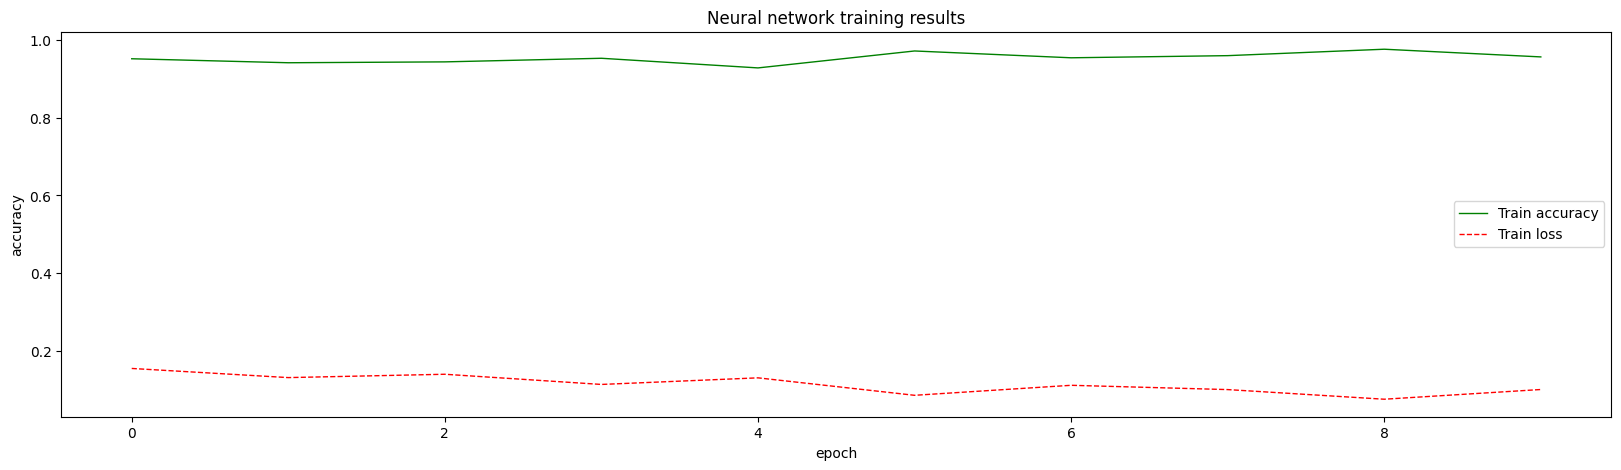

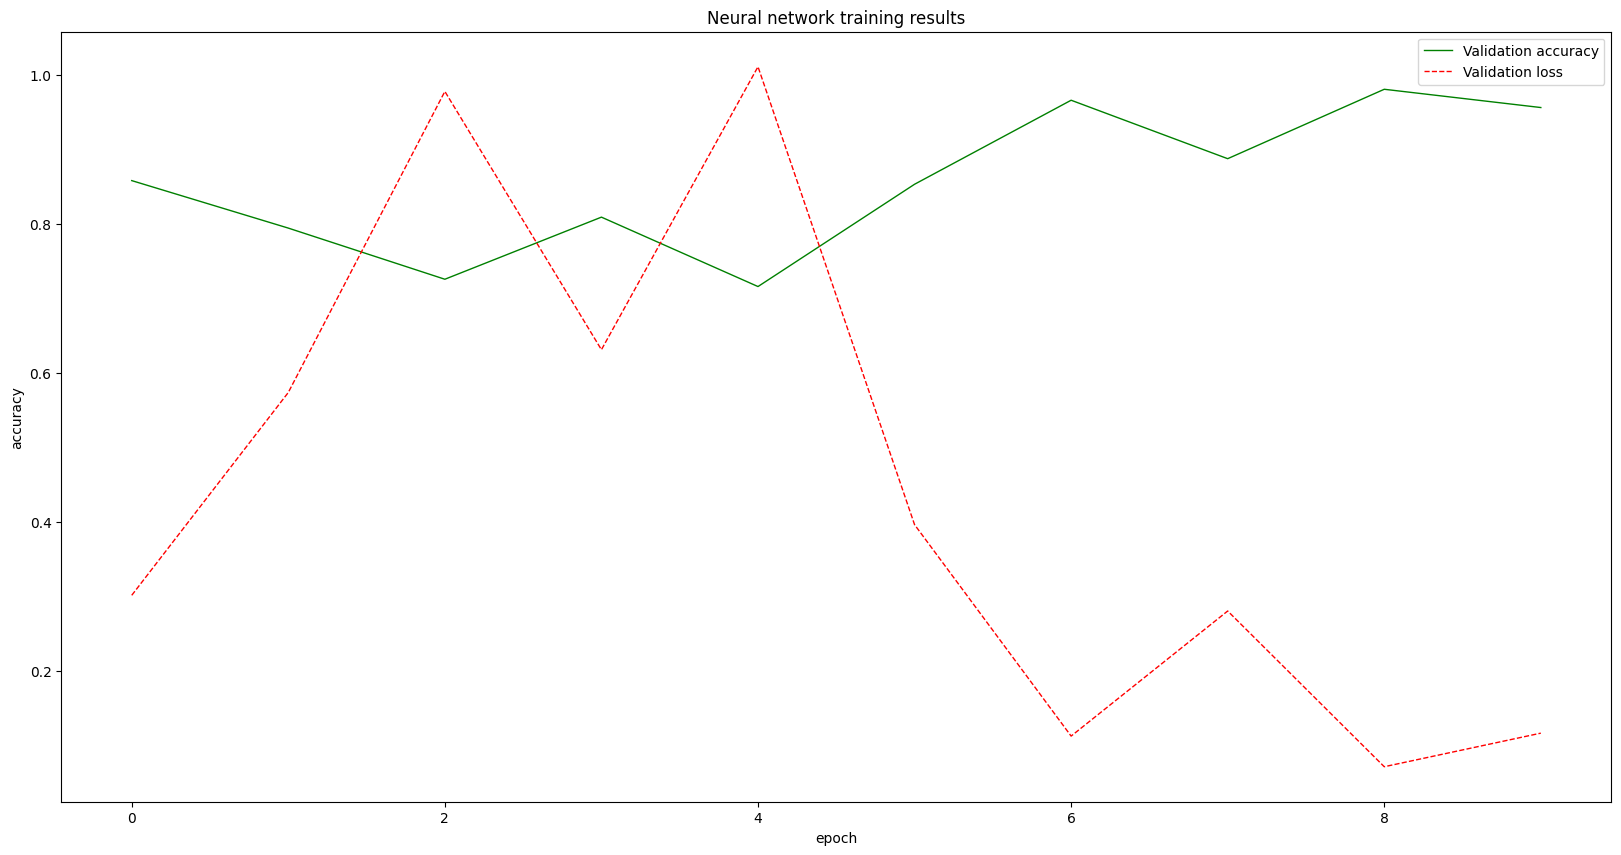

In [25]:
train_loop(10, 400, 0.002)

Epoch : 1, train accuracy : 0.9240278005599976, train loss : 0.18729528784751892
Epoch : 1, val_accuracy : 0.8274999856948853, val_loss : 0.3858819007873535
Epoch : 2, train accuracy : 0.9280556440353394, train loss : 0.1529114842414856
Epoch : 2, val_accuracy : 0.9724999666213989, val_loss : 0.06848413497209549
Epoch : 3, train accuracy : 0.9445832967758179, train loss : 0.14949342608451843
Epoch : 3, val_accuracy : 0.8650000095367432, val_loss : 0.37281468510627747
Epoch : 4, train accuracy : 0.9522221684455872, train loss : 0.11652657389640808
Epoch : 4, val_accuracy : 0.7775000333786011, val_loss : 0.5295689105987549
Epoch : 5, train accuracy : 0.9555554986000061, train loss : 0.11721684783697128
Epoch : 5, val_accuracy : 0.9624999761581421, val_loss : 0.07452408224344254
Epoch : 6, train accuracy : 0.9549999833106995, train loss : 0.09479092806577682
Epoch : 6, val_accuracy : 0.9774999618530273, val_loss : 0.07760807871818542
Epoch : 7, train accuracy : 0.9561111330986023, train l

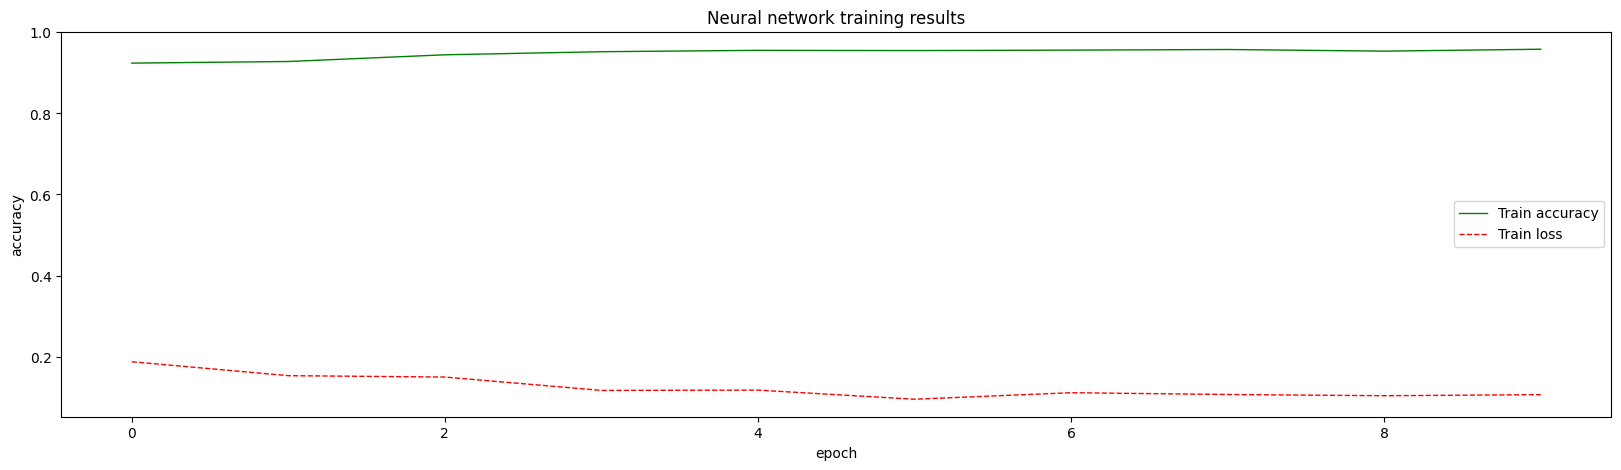

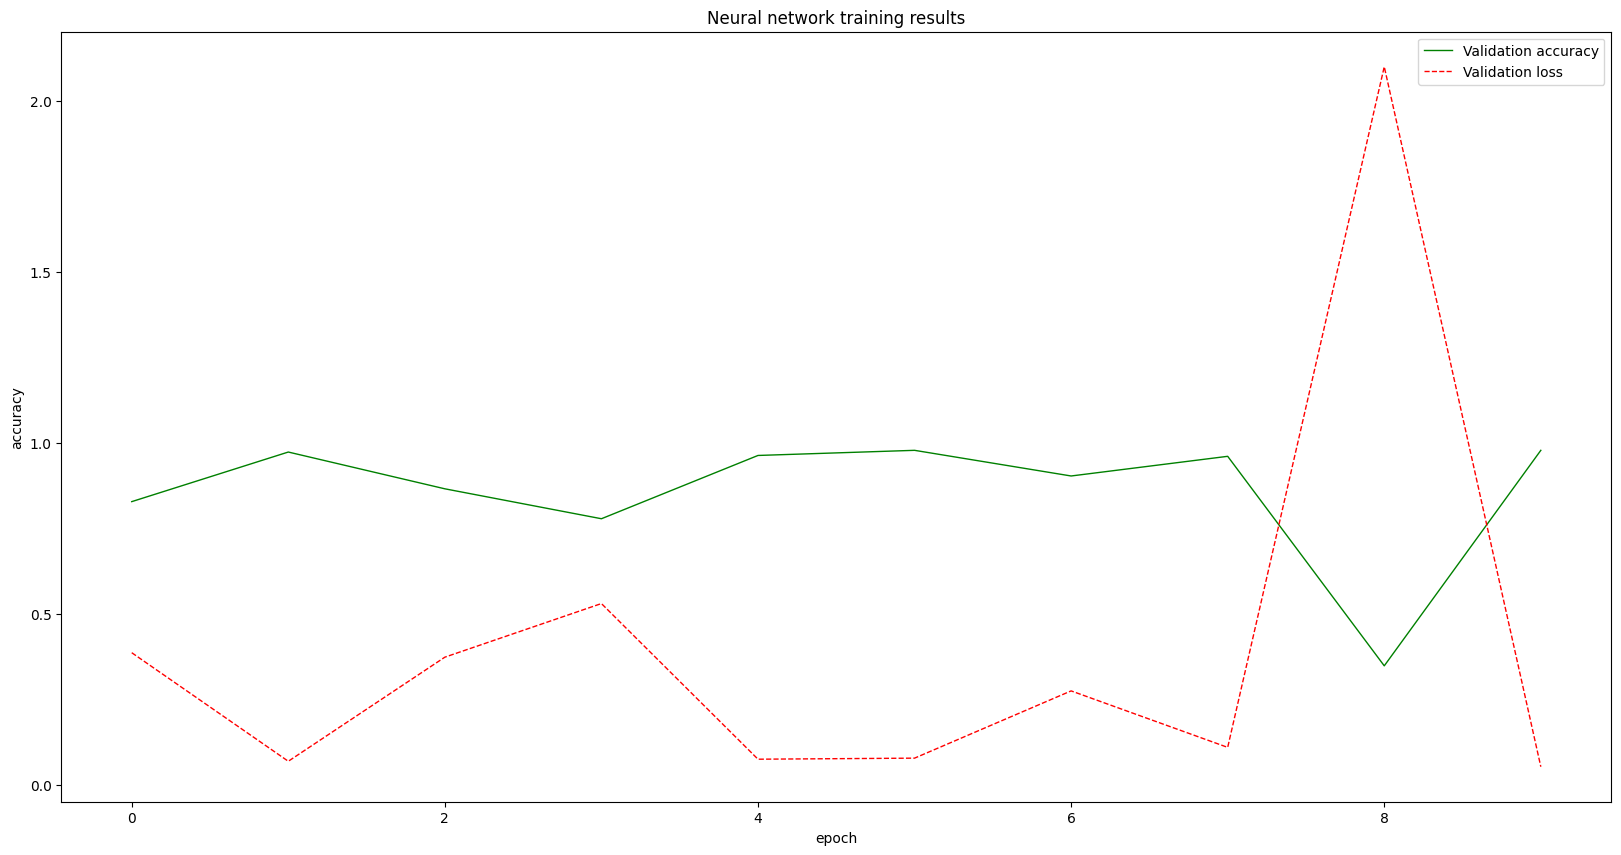

In [26]:
train_loop(10, 200, 0.003)

Epoch : 1, train accuracy : 0.9337499141693115, train loss : 0.17552980780601501
Epoch : 1, val_accuracy : 0.5441176295280457, val_loss : 2.518825054168701
Epoch : 2, train accuracy : 0.9164999723434448, train loss : 0.1574556529521942
Epoch : 2, val_accuracy : 0.8627451062202454, val_loss : 0.29557475447654724
Epoch : 3, train accuracy : 0.9352499842643738, train loss : 0.14509987831115723
Epoch : 3, val_accuracy : 0.8529411554336548, val_loss : 0.25771069526672363
Epoch : 4, train accuracy : 0.9340000152587891, train loss : 0.14045092463493347
Epoch : 4, val_accuracy : 0.8480392098426819, val_loss : 0.4451923370361328
Epoch : 5, train accuracy : 0.9477499723434448, train loss : 0.11834513396024704
Epoch : 5, val_accuracy : 0.813725471496582, val_loss : 0.514834463596344
Epoch : 6, train accuracy : 0.9587500095367432, train loss : 0.09430718421936035
Epoch : 6, val_accuracy : 0.8186274766921997, val_loss : 0.4534008204936981
Epoch : 7, train accuracy : 0.9627499580383301, train loss :

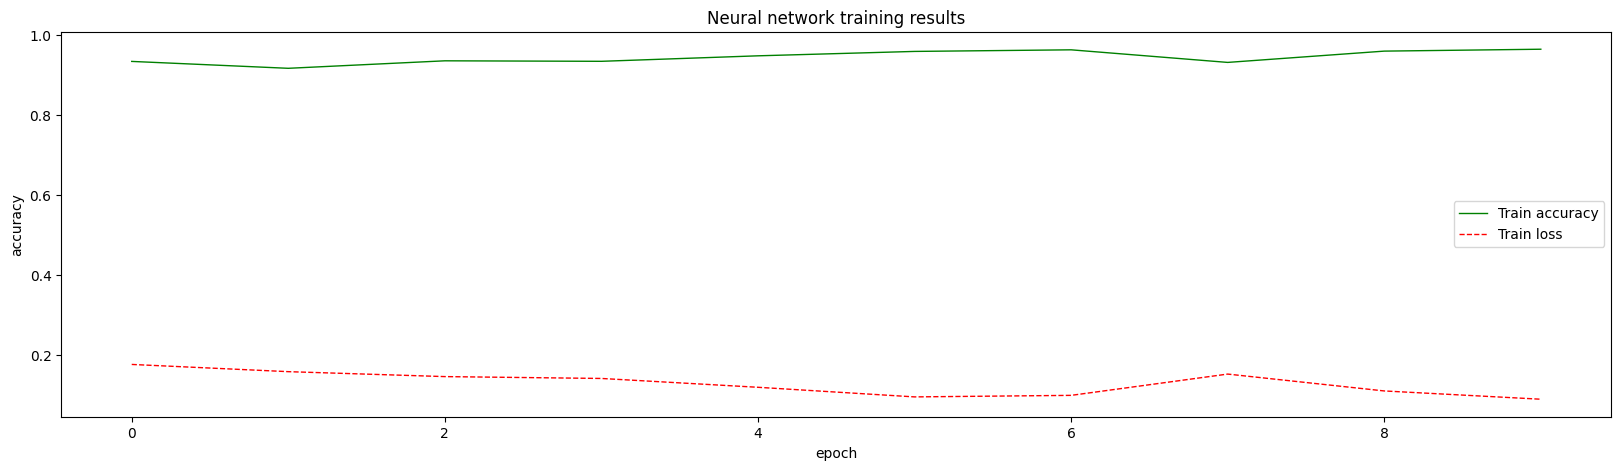

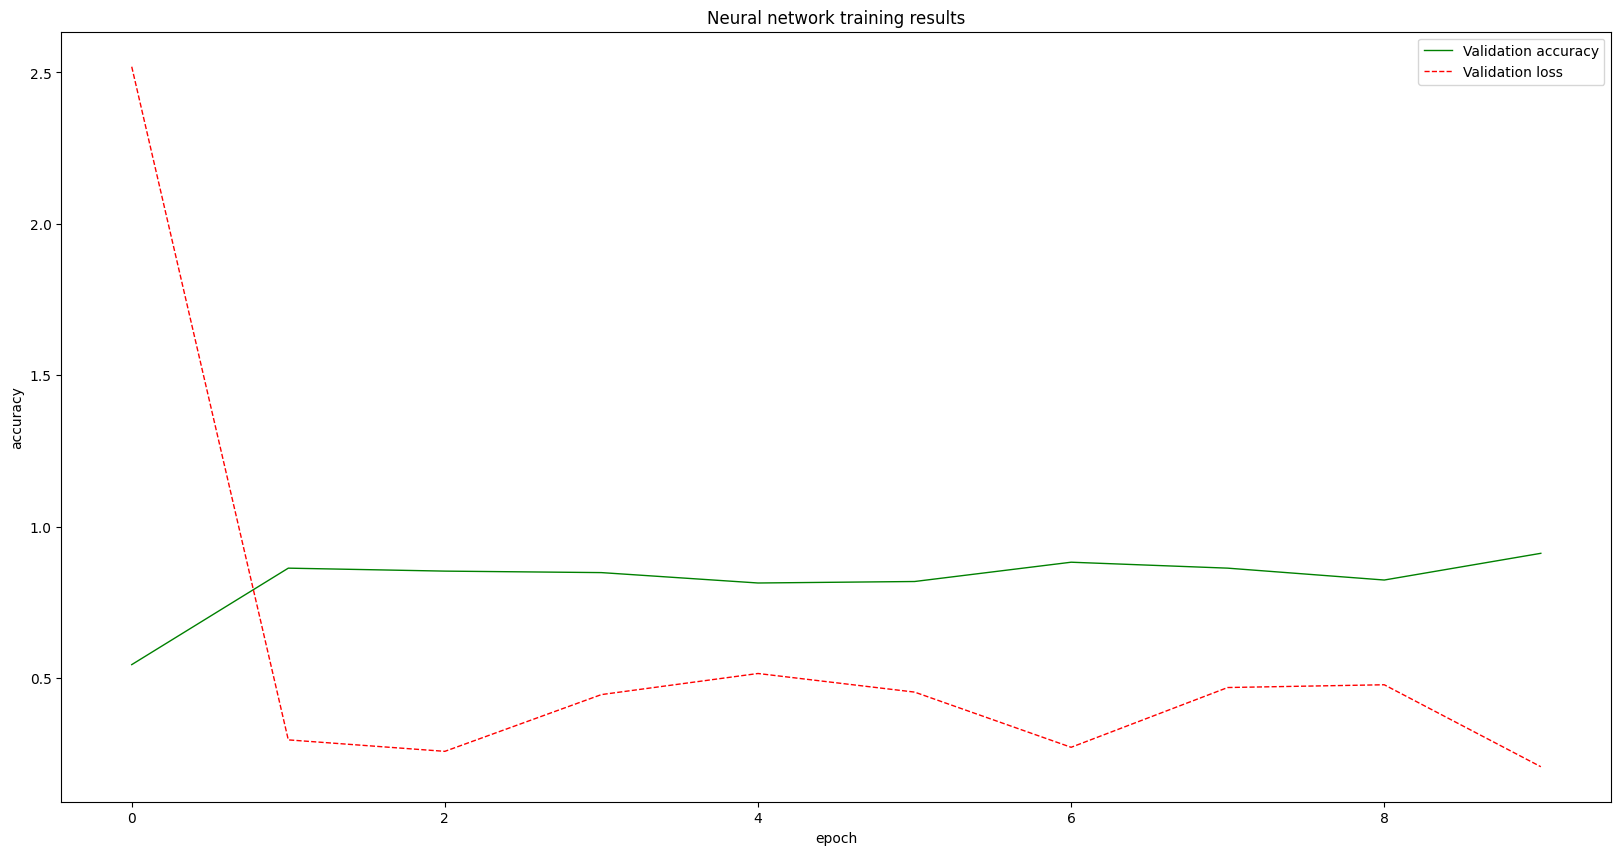

In [27]:
train_loop(10, 400, 0.003)

Проверка на тестовой выборке

Сохранение

In [38]:
torch.save(model.state_dict(), "trained_model.pt")

Загрузка модели

In [22]:
model = CNN()
model.load_state_dict(torch.load("trained_model.pt"))
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Проверка на тестовом промежутке данных

In [132]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
test_loader = torch.utils.data.DataLoader(
        dataset=test_data, batch_size=100, shuffle=False
    )
model.eval()
test_loss = 0
test_accuracy = 0
for data, label in test_loader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    loss = criterion(output, label)

    acc = (output.argmax(dim=1) == label).float().mean()
    test_accuracy += acc
    test_loss += float(loss.detach()) 
test_accuracy / len(test_loader), test_loss/ len(test_loader)

(tensor(0.8700), 0.22013871123393378)

Проверка рандомных картинок

C:\Users\zabir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AttributeError: 'Tensor' object has no attribute 'detauch'

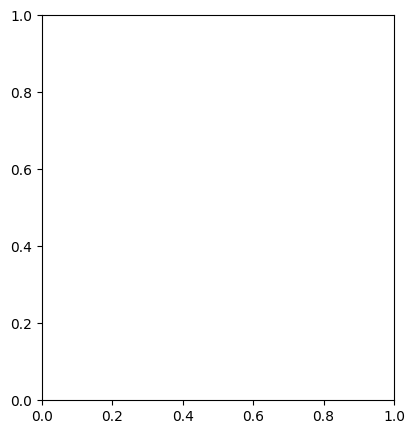

In [26]:
plt.figure(figsize=(10, 5))

for j in range(2):
  index = random.randint(0, 2)
  plt.subplot(1, 2, j + 1)
  print(model(test_data[index][0].unsqueeze(dim=0).to(device)))
  plt.title("dog" if (1 if  model(test_data[index][0].unsqueeze(dim=0).to(device))[0] >= 0.5 else 0) == 0 else "cat")
  plt.imshow(test_data[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])
